In [1]:
!pip install stable-baselines==2.9.0

     |████████████████████████████████| 235kB 24.1MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [2]:
import datetime
from time import time
from collections import deque

import numpy as np

import torch as T
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
from torch.distributions import Categorical
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack, VecNormalize
from stable_baselines.common.running_mean_std import RunningMeanStd

from tqdm import trange
from google.colab import drive
from itertools import count

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
ENV_NAME = 'BankHeistNoFrameskip-v4'
SAVE_PATH = '/content/gdrive/My Drive/ICM/'

TOTAL_FRAMES = 5e6   # 10 million frames
ROLLOUT_LENGTH = 128  # transitions in each rollout
NENV = 8            # parallel environments, increase to decorrolate batches
GAMMA = 0.99        # reward discounting coefficient
LAMBDA = 0.95       # for GAE
SEED = 420          # blaze it
STEPS_PER_ROLLOUT = ROLLOUT_LENGTH*NENV
TOTAL_UPDATES = int(TOTAL_FRAMES // STEPS_PER_ROLLOUT)
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')

set_global_seeds(SEED)

# Neural Net Definitions

In [0]:
def conv_size(net, in_shape):
    """ util for calculating flat output shape of a given net """
    x = Variable(T.rand(1, *in_shape))
    o = net(x)
    b = (-1, o.size(1), o.size(2), o.size(3))
    return b, o.data.view(1, -1).size(1)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0.01)
        elif 'weight' in name:
            nn.init.kaiming_uniform_(param, mode='fan_in', nonlinearity='relu')

In [0]:
class AC(nn.Module):
  
    def __init__(self, input_shape, num_actions):
        super().__init__()
        h, w, c = input_shape

        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, 8, 4),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(True),
        )

        _,f = conv_size(self.conv, (c,h,w))
        
        self.backbone = nn.Sequential(self.conv, nn.Flatten())
        self.actor = nn.Linear(f, num_actions)
        self.critic = nn.Linear(f, 1)
        
        self.apply(init_weights)

    def forward(self, x):
        latent = self.backbone(x)
        return self.actor(latent), self.critic(latent)

In [0]:
class ICM(nn.Module):
    """ ICM sources its intrinsic bonus from the ability of a predictor
        network to estimate the action that was taken by the policy,
        given as input two latent encodings (phi) of two adjacent states
        (phi(S_t), phi(S_t+1)).
    """
    def __init__(self, input_shape, num_actions, latent_size):
        super().__init__()
        h, w, c = input_shape
        self.latent_size = latent_size
        self.num_actions = num_actions

        # 'features' from the paper diagram
        # transform state into phi/latent representation
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(c, 32, 8, 4),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU(True),
        )
        self.encoder_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_size(self.encoder_conv, (c,h,w))[1], 512),
            nn.ReLU(True),
            nn.Linear(512, self.latent_size)
        )
        self.encoder = nn.Sequential(
            self.encoder_conv, 
            self.encoder_linear
        )
        
        # predict encoder(S_t+1) from encoder(S_t + A_t)
        self.forward_model = nn.Sequential(
            nn.Linear(self.latent_size + self.num_actions, 256),
            nn.ReLU(),
            nn.Linear(256, self.latent_size)
        )

        # predict A_t from (S_t+1, S_t)
        self.inverse_model = nn.Sequential(
            nn.Linear(self.latent_size * 2, 256),
            nn.ReLU(),
            nn.Linear(256, self.num_actions)
        )

    def one_hot_actions(self, actions):
        # actions are vector b/c env is VecEnv
        z = T.zeros((len(actions), self.num_actions)).float().to(DEVICE)
        for i in range(len(actions)):
            z[i,actions[i]] = 1.0
        return z

    def forward(self, state, next_state, actions):
        """ returns (inverse loss, forward loss/intrinsic bonus) """
        # encode states into latent space
        phi_state = self.encoder(state)
        phi_next_state = self.encoder(next_state)
        # predict phi(S_t+1) given S_t and A_t
        a = self.one_hot_actions(actions)

        fwd_phi_act = T.cat([phi_state, a], dim=1)
        phi_next_state_pred = self.forward_model(fwd_phi_act)
        # predict the actions taken to get from S_t to S_t+1
        rev = T.cat([phi_state, phi_next_state], 1)
        actions_pred = self.inverse_model(rev)

        # backprop to inverse model and encoder
        inverse_loss = F.cross_entropy(actions_pred, actions)
        # backprop to forward model and encoder
        forward_loss = F.mse_loss(phi_next_state, 
                                  phi_next_state_pred.detach(), 
                                  reduce=False).sum(-1)

        return inverse_loss, forward_loss

# Logging utils

In [0]:
class Logger:

    def __init__(self, print_rate=250):
        self.log = {'ep_r':[], 'ep_l':[], 'loss':[], 'pgloss':[], 
                    'vloss':[], 'ent':[], 'int':[], 'icm':[]}
        self.n_ep = 0              # total games/episodes
        self.n_update = 1          # total weight updates
        self.n_frames = 0          # env steps (total from checkpoint)
        self.run_frames = 0        # env steps (for this run)
        self.max_rwd = -np.inf     # max rwd out of all games played
        self.start_time = time()   # time we started *this* run
        self.last_checkpoint = 0   # total_frames at last checkpoint
        self.print_rate = print_rate

    def eta(self):  # get hh:mm:ss left to train
        elapsed_time = time() - self.start_time
        frames_left = TOTAL_FRAMES - self.n_frames
        sec_per_frame = elapsed_time / self.n_frames
        sec_left = int(frames_left * sec_per_frame)
        eta_str = str(datetime.timedelta(seconds=sec_left))
        return eta_str

    def fps(self):  # get frames per second
        elapsed_time = time() - self.start_time
        fps = int(self.run_frames / elapsed_time)
        return fps

    def sma(self, x):  # simple moving average
        if len(x) == 0: return 'NaN'
        div = 200 if len(x) > 200 else len(x)
        return sum(list(zip(*x[-div:]))[-1])/div

    def print_log(self):
        fps = self.fps()
        eta = self.eta()
        print('-'*10, self.n_update, '/', TOTAL_UPDATES, '-'*10)
        print('Num Games:', self.n_ep)
        print('Num Frames:', self.n_frames)
        print('FPS:', fps)
        print('ETA:', eta)
        print('SMA Length:', self.sma(self.log['ep_l']))
        print('SMA Reward:', self.sma(self.log['ep_r']))
        print('SMA Entropy:', self.sma(self.log['ent']))
        print('SMA Loss:', self.sma(self.log['loss']))
        print('SMA PG Loss:', self.sma(self.log['pgloss']))
        print('SMA V Loss:', self.sma(self.log['vloss']))
        print('SMA Intrinsic Reward:', self.sma(self.log['int']))
        print('SMA ICM Loss:', self.sma(self.log['icm']))
        print('Max reward:', self.max_rwd)

    def record(self, ep, loss, pgloss, vloss, ent, intr, icm):
        
        self.n_update += 1
        self.n_frames += STEPS_PER_ROLLOUT
        self.run_frames += STEPS_PER_ROLLOUT
        fr = (self.n_frames, self.n_update)

        # stats about finished episodes/games
        for l, r in zip(ep['l'], ep['r']):
            self.log['ep_l'].append(fr+(l,))
            self.log['ep_r'].append(fr+(r,))
            if r > self.max_rwd: self.max_rwd = r
            self.n_ep += 1
             
        # nn training statistics
        self.log['loss'].append(fr+(loss,))
        self.log['pgloss'].append(fr+(pgloss,))
        self.log['vloss'].append(fr+(vloss,))
        self.log['ent'].append(fr+(ent,))
        self.log['int'].append(fr+(intr,))
        self.log['icm'].append(fr+(icm,))
        
        # print log
        if self.n_update % self.print_rate == 0:
            self.print_log()

# Rollout handling

In [0]:
def ob_to_torch(x):
    x = np.moveaxis(x, -1, 1)
    x = T.from_numpy(x).float()
    x = x.to(DEVICE)
    return x

In [0]:
def GAE(rwds, vals, next_val, dones=None):
    """ GAE lambda. vals is full batch, next_val is singular """
    returns = T.empty_like(rwds).to(DEVICE)
    if dones is None: dones = T.ones_like(rwds, dtype=T.bool)
    g = 0
    for i in reversed(range(ROLLOUT_LENGTH)):
        d = rwds[i] + (GAMMA * next_val * ~dones[i]) - vals[i]
        g = d + (GAMMA * LAMBDA * ~dones[i] * g)
        returns[i] = g + vals[i]
        next_val = vals[i]
    adv = returns - vals
    return returns, adv

In [0]:
def rollout_generator(env, policy):

    ob = ob_to_torch(env.reset())
    mb = {'obs':[], 'nobs':[], 'act':[], 'rwd':[], 'done':[], 'val':[]}
    ep = {'l':[], 'r':[]}  # len & total reward of done eps 
    
    for step in count(1):

        # we compute gradients in the train loop
        with T.no_grad():
            logits, val = policy(ob)
            dist = Categorical(logits=logits)
            action = dist.sample()
        
        new_ob, rwd, done, info = env.step(action)
        
        # store transition
        mb['obs'].append(ob)
        mb['act'].append(action)
        mb['rwd'].append(T.from_numpy(rwd))
        mb['val'].append(val.view(-1))
        mb['done'].append(T.from_numpy(done))
        for t in info:
            if t.get('episode'):
                ep['l'].append(t['episode']['l'])
                ep['r'].append(t['episode']['r'])

        ob = ob_to_torch(new_ob)

        if step % ROLLOUT_LENGTH != 0:
            continue

        ########################################################
        ###   Flatten rollout & assign credit w/ GAE         ###
        ########################################################

        # next obs for ICM
        mb['nobs'] = mb['obs'][1:] + [ob]

        # list(tensor) -> tensor
        for k in mb.keys():
            mb[k] = T.stack(mb[k]).to(DEVICE)

        # bootstap generalized advantages
        with T.no_grad():
            next_val = policy(ob)[1].view(-1) * ~mb['done'][-1]
            mb['rtn'], mb['gae'] = GAE(mb['rwd'], mb['val'], next_val, mb['done'])

        # flatten to (NENV*ROLLOUT_LENGTH, ...)
        for k in mb.keys():
            s = mb[k].size()
            mb[k] = mb[k].view(STEPS_PER_ROLLOUT, *s[2:])
        
        yield mb, ep
        mb = {'obs':[], 'nobs':[], 'act':[], 'rwd':[], 'done':[], 'val':[]}
        ep = {'l':[], 'r':[]}

# Checkpoint loading and saving

In [0]:
def new_run():
    """ setup parallelised gym environments (MaxAndSkip=4 by default) """
    env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
    env._max_episode_steps = 4500*4
    env = VecFrameStack(env, n_stack=4)
    env = VecNormalize(env, norm_reward=False, clip_reward=1e5, gamma=1.0)
    in_dim = env.observation_space.shape
    policy_dim = env.action_space.n

    # get actor + critic
    ac = AC(in_dim, policy_dim).to(DEVICE)
    ac_optimizer = Adam(ac.parameters(), 1e-4, eps=1e-5)

    # get intrinsic curiosity module
    icm = ICM(in_dim, policy_dim, 128).to(DEVICE)
    icm_optimizer = Adam(icm.parameters(), 1e-4, eps=1e-5)

    logger = Logger(25)

    return env, ac, ac_optimizer, icm, icm_optimizer, logger

In [0]:
def save_checkpoint(checkpoint_id):
    checkpoint = {
        'env': env,
        'ac': ac.state_dict(),
        'ac_opt': ac_optimizer.state_dict(),
        'icm': icm.state_dict(),
        'icm_opt': icm_optimizer.state_dict(),
        'logger': logger
    }
    fn = SAVE_PATH+str(checkpoint_id)+ENV_NAME+'.checkpoint.p'
    T.save(checkpoint, fn)

In [0]:
def load_checkpoint(file_name):
    checkpoint = T.load(file_name)
    
    venv = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
    venv = VecFrameStack(venv, n_stack=4)
    env = checkpoint['env']
    env.set_venv(venv)
    in_dim = env.observation_space.shape
    policy_dim = env.action_space.n

    ac = AC(in_dim, policy_dim).to(DEVICE)
    ac.load_state_dict(checkpoint['ac'])
    ac_optimizer = Adam(ac.parameters())
    ac_optimizer.load_state_dict(checkpoint['ac_opt'])

    icm = ICM(in_dim, policy_dim, 128).to(DEVICE)
    icm.load_state_dict(checkpoint['icm'])
    icm_optimizer = Adam(icm.parameters())
    icm_optimizer.load_state_dict(checkpoint['icm_opt'])

    logger = checkpoint['logger']

    return env, ac, ac_optimizer, icm, icm_optimizer, logger

# Load checkpoint or begin new run

In [0]:
env, ac, ac_optimizer, icm, icm_optimizer, logger = new_run()
# env, ac, ac_optimizer, icm, icm_optimizer, logger = load_checkpoint(SAVE_PATH+'FINALPongNoFrameskip-v4.checkpoint.p')

# Train!

In [17]:
rollouts = rollout_generator(env, ac)
scheduler = LambdaLR(ac_optimizer, lambda i: 1 - i / TOTAL_UPDATES)

for i_update in range(logger.n_update, TOTAL_UPDATES):

    mb, ep = next(rollouts)

    # policy gradient + entropy
    logits, val = ac(mb['obs'])
    dist = Categorical(logits=logits)
    ent = dist.entropy().mean()
    logp = dist.log_prob(mb['act'])
    
    # intrinsic reward (not baselined)
    inverse_loss, forward_mse = icm(mb['obs'], mb['nobs'], mb['act'])
    int_rwd = forward_mse.detach()

    # normalized extrinsic + intrinsic advantage
    adv = mb['gae']*0.99 + int_rwd*0.01
    adv = (adv - adv.mean()) / (adv.std() + 1e-8)

    # calculate losses (soft ac with entropy)
    vloss = (val.view(-1) - mb['rtn']).pow(2).mean()
    pgloss = -(adv * logp).mean()
    loss = pgloss + 0.5*vloss - 0.01*ent
    
    # step policy
    ac_optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(ac.parameters(), 0.5)
    ac_optimizer.step()
    scheduler.step(i_update)
    
    # step icm
    icm_loss = 0.8*inverse_loss.mean() + 0.2*forward_mse.mean()
    icm_optimizer.zero_grad()
    icm_loss.backward()
    nn.utils.clip_grad_norm_(icm.parameters(), 0.5)
    icm_optimizer.step()
    
    # log training stats
    logger.record(ep, loss.item(), pgloss.item(), vloss.item(), ent.item(),
                  int_rwd.mean().item(), icm_loss.item())
    # make a checkpoint every 1m frames
    if logger.n_frames - logger.last_checkpoint > 1e6:
        save_checkpoint(logger.n_frames)
        logger.last_checkpoint = logger.n_frames
    
#     if i_update % 25 == 0:
#         print('SOFTMAX: ', dist.probs)
        
save_checkpoint('FINAL')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


---------- 25 / 4882 ----------
Num Games: 38
Num Frames: 24576
FPS: 421
ETA: 3:16:36
SMA Length: 601.2368421052631
SMA Reward: 10.0
SMA Entropy: 2.350403060515722
SMA Loss: 0.056991323518256344
SMA PG Loss: 0.018910148219826322
SMA V Loss: 0.12317041431864102
SMA Intrinsic Reward: 0.11411378905177116
SMA ICM Loss: 2.339827537536621
Max reward: 40.0
---------- 50 / 4882 ----------
Num Games: 81
Num Frames: 50176
FPS: 423
ETA: 3:14:42
SMA Length: 606.1111111111111
SMA Reward: 12.098765432098766
SMA Entropy: 2.2714943374906267
SMA Loss: 0.02702409747455801
SMA PG Loss: 0.00980481782890096
SMA V Loss: 0.07986844661740625
SMA Intrinsic Reward: 0.08915784688932556
SMA ICM Loss: 2.3223358417043882
Max reward: 60.0
---------- 75 / 4882 ----------
Num Games: 126
Num Frames: 75776
FPS: 425
ETA: 3:13:01
SMA Length: 594.3333333333334
SMA Reward: 12.777777777777779
SMA Entropy: 2.2309601226368465
SMA Loss: 0.01808483079327522
SMA PG Loss: 0.008395604625646327
SMA V Loss: 0.06399765497425923
SMA In

# Save final model and log

In [18]:
save_checkpoint('FINAL')
T.save(logger.log, SAVE_PATH+'FINAL.'+ENV_NAME+'.log')
T.save(ac, SAVE_PATH+'FINAL.'+ENV_NAME+'.MODEL')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Plot results

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

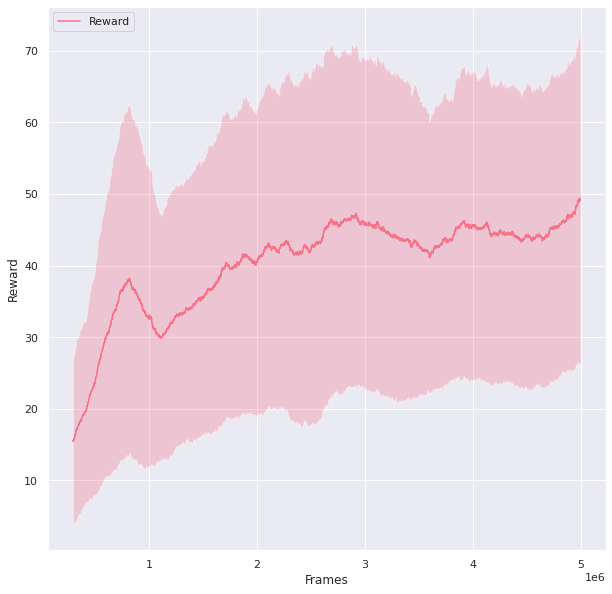

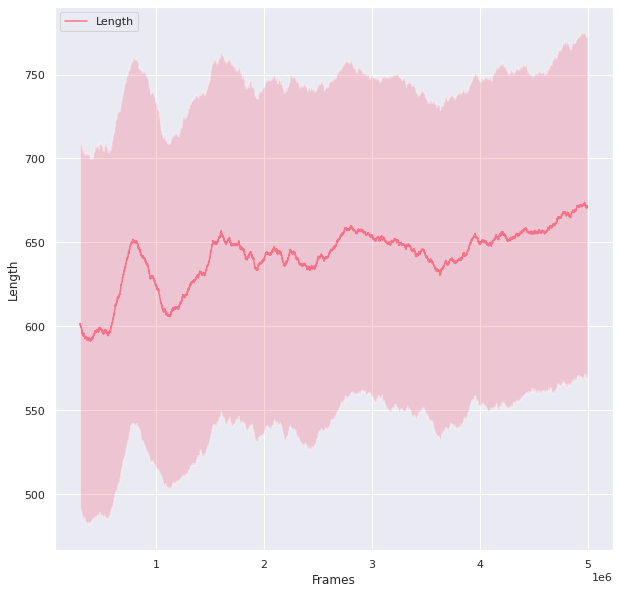

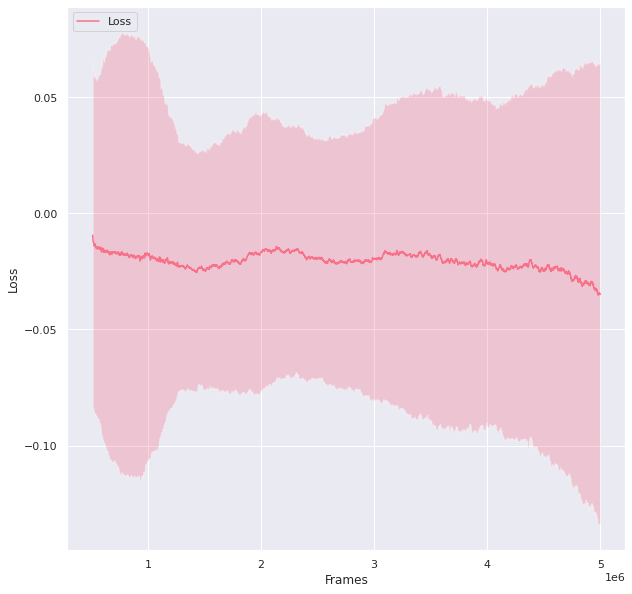

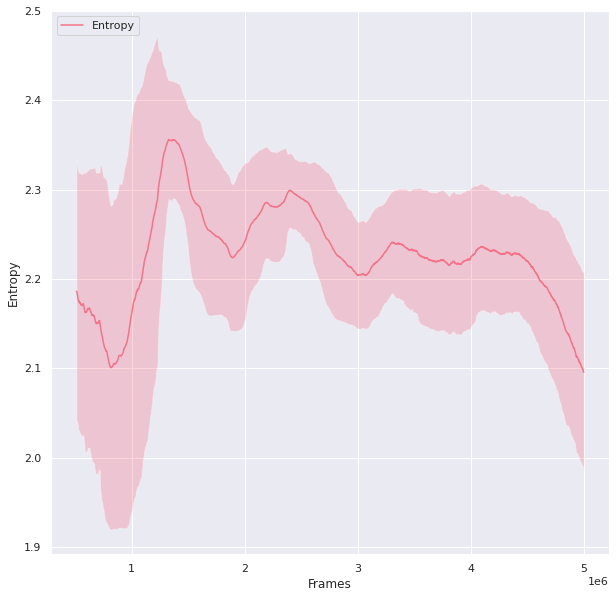

In [20]:
def plot_log(log, ylabel):
    # compute rolling avg and std
    df = pd.DataFrame(log, columns =['Frames', 'Iters', ylabel])
    sma_y = df[ylabel].rolling(500).mean()
    std_y = df[ylabel].rolling(500).std()
    
    # plot with seaborn
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel('Frames')
    ax.set_ylabel(ylabel)
    clrs = sns.color_palette("husl", 8)

    # fill standard deviation
    ax.plot(df['Frames'], sma_y, label=ylabel, c=clrs[0])
    ax.fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                    alpha=0.3, facecolor=clrs[0]) 
    ax.legend(loc='upper left')
    plt.savefig(SAVE_PATH+ENV_NAME+'.'+ylabel+'.plt.png', 
                dpi=300, pad_inches=0)
    plt.show()

plot_log(logger.log['ep_r'], 'Reward')
plot_log(logger.log['ep_l'], 'Length')
plot_log(logger.log['loss'], 'Loss')
plot_log(logger.log['ent'], 'Entropy')

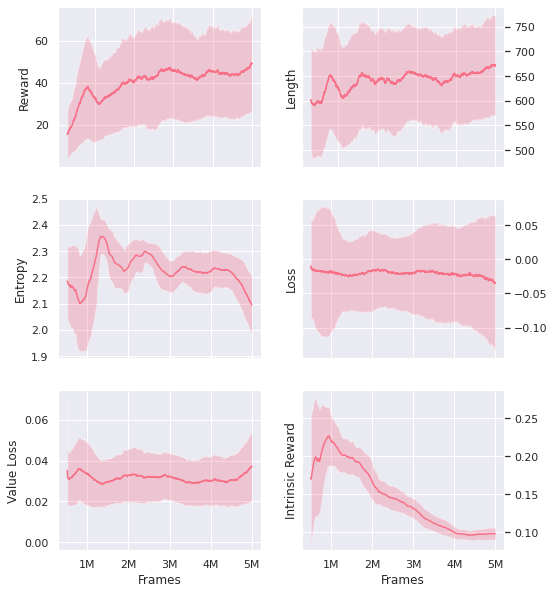

In [21]:
fig_all, ax_all = plt.subplots(3,2, figsize=(8,10))

## REWARD 
df = pd.DataFrame(logger.log['ep_r'], columns =['Frames', 'Iters', 'rwd'])
sma_y = df['rwd'].rolling(500).mean()
std_y = df['rwd'].rolling(500).std()

ax_all[0][0].set_ylabel('Reward')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[0][0].plot(df['Frames'], sma_y, label='Episode Reward', c=clrs[0])
ax_all[0][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
ax_all[0][0].set_xticklabels('')


## LENGTH 
df = pd.DataFrame(logger.log['ep_l'], columns =['Frames', 'Iters', 'Len'])
sma_y = df['Len'].rolling(500).mean()
std_y = df['Len'].rolling(500).std()

ax_all[0][1].set_ylabel('Length')
ax_all[0][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[0][1].plot(df['Frames'], sma_y, label='Episode Length', c=clrs[0])
ax_all[0][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
ax_all[0][1].set_xticklabels('')


## ENTROPY 
df = pd.DataFrame(logger.log['ent'], columns =['Frames', 'Iters', 'ent'])
sma_y = df['ent'].rolling(500).mean()
std_y = df['ent'].rolling(500).std()

ax_all[1][0].set_ylabel('Entropy')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[1][0].plot(df['Frames'], sma_y, label='Entropy', c=clrs[0])
ax_all[1][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[1][0].get_xticks()/1e6]
ax_all[1][0].set_xticklabels('')


## LOSS 
df = pd.DataFrame(logger.log['loss'], columns =['Frames', 'Iters', 'Loss'])
sma_y = df['Loss'].rolling(500).mean()
std_y = df['Loss'].rolling(500).std()

ax_all[1][1].set_ylabel('Loss')
ax_all[1][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[1][1].plot(df['Frames'], sma_y, label='Loss', c=clrs[0])
ax_all[1][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[1][1].get_xticks()/1e6]
ax_all[1][1].set_xticklabels('')


## V LOSS 
df = pd.DataFrame(logger.log['vloss'], columns =['Frames', 'Iters', 'Loss'])
sma_y = df['Loss'].rolling(500).mean()
std_y = df['Loss'].rolling(500).std()

ax_all[2][0].set_xlabel('Frames')
ax_all[2][0].set_ylabel('Value Loss')
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[2][0].plot(df['Frames'], sma_y, label='V Loss', c=clrs[0])
ax_all[2][0].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[2][0].get_xticks()/1e6]
ax_all[2][0].set_xticklabels(xlabels)


## INTRINSIC REWARD
df = pd.DataFrame(logger.log['int'], columns =['Frames', 'Iters', 'Int'])
sma_y = df['Int'].rolling(500).mean()
std_y = df['Int'].rolling(500).std()

ax_all[2][1].set_xlabel('Frames')
ax_all[2][1].set_ylabel('Intrinsic Reward')
ax_all[2][1].yaxis.tick_right()
clrs = sns.color_palette("husl", 8)

# fill standard deviation
ax_all[2][1].plot(df['Frames'], sma_y, label='Intrinsic Reward', c=clrs[0])
ax_all[2][1].fill_between(df['Frames'], sma_y-std_y,  sma_y+std_y, 
                alpha=0.3, facecolor=clrs[0])

# make x axis nice
xlabels = [f'{int(x)}M' for x in ax_all[2][1].get_xticks()/1e6]
ax_all[2][1].set_xticklabels(xlabels)

plt.savefig(SAVE_PATH+ENV_NAME+'_plot_thesis.png', 
            dpi=300, pad_inches=0, bbox_inches = 'tight')

plt.show()